In [19]:
import numpy as np
import pickle
from glob import glob
import corner
from mcmc import Ebola

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
par = ('beta', 'k', 'tau', 'sigma', 'gamma', 'f', 'offset',
       'scatter_cases', 'prob_cases_outlier',
       'scatter_deaths', 'prob_deaths_outlier')
ndim = len(par)  # number of parameters in the model
N = 1000000

In [3]:
country = 'guinea'
#country = 'liberia'
#country = 'sierraleone'

In [5]:
binning = 'weekly'
#binning = 'daily'

In [6]:
e = Ebola(N, country, weekly=binning=='weekly')

In [7]:
filename = '{}/logs/{}/run15/chains/chain.txt'.format(binning, country)
print(filename)

weekly/logs/guinea/run1/chains/chain.txt


In [8]:
data = np.loadtxt(filename)

In [9]:
chain = data[:, 2:]
lnprob = -data[:, 1]
weight = data[:, 0]
###weight = weight * 0 + 1
weight /= weight.sum()

In [10]:
chain.shape

(2560, 11)

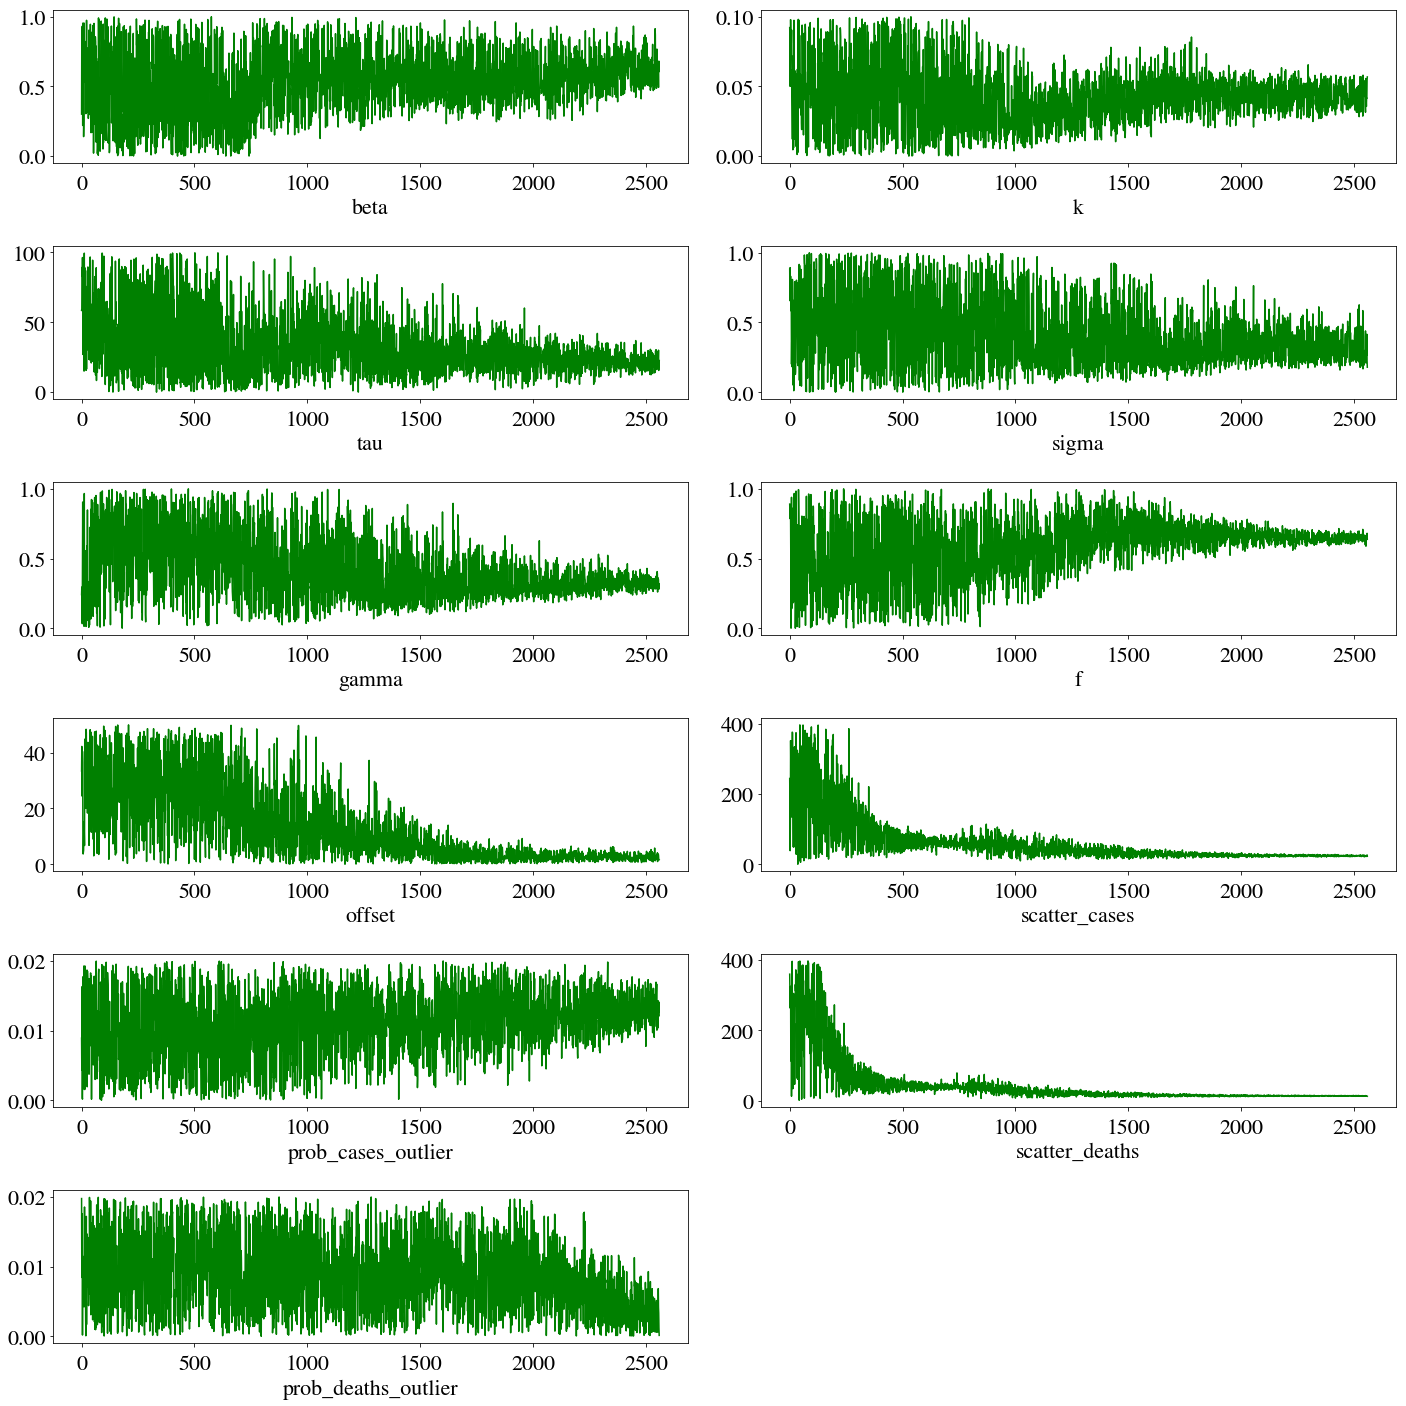

In [11]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    plt.plot(numpy.arange(chain.shape[0]), chain[:,i], 'g-')
    plt.xlabel(p)
    aymin, aymax = plt.ylim()
    plt.ylim(aymin, aymax)
    plt.tight_layout()
plt.savefig('plots/nnest_all_chains_{}.pdf'.format(country))

In [12]:
def round_sig(x, sig=1):
    d = sig-int(floor(log10(x)))-1
    d = max(0, d)
    return round(x, d), d


def summary(samples, truths=None, filename=None, weight=None):
    mean = np.average(samples, axis=0, weights=weight)
    sigma = np.sqrt(np.average((samples-mean)**2, axis=0, weights=weight))
    if filename is not None:
        f = open(filename, 'a')
    else:
        f = None
    for i, p in enumerate(par):
        err, dp = round_sig(sigma[i], 1)
        val = round(mean[i], dp)
        dp = str(dp)
        dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        outstr = ('{:22s} = {:6.'+dp+' ± {:<8.'+dp).format(p, val, err)
        if truths is not None:
            outstr += ('   ('+dp+')').format(truths[i])
        print(outstr, file=f)
    if filename is not None:
        f.close()

In [13]:
summary(chain)
summary(chain, filename='nest_summary_{}'.format(country))

beta                   =    0.5 ± 0.2     
k                      =   0.04 ± 0.02    
tau                    =     31 ± 21      
sigma                  =    0.4 ± 0.2     
gamma                  =    0.4 ± 0.2     
f                      =    0.6 ± 0.2     
offset                 =     12 ± 13      
scatter_cases          =     58 ± 61      
prob_cases_outlier     =  0.011 ± 0.005   
scatter_deaths         =     42 ± 63      
prob_deaths_outlier    =  0.009 ± 0.005   


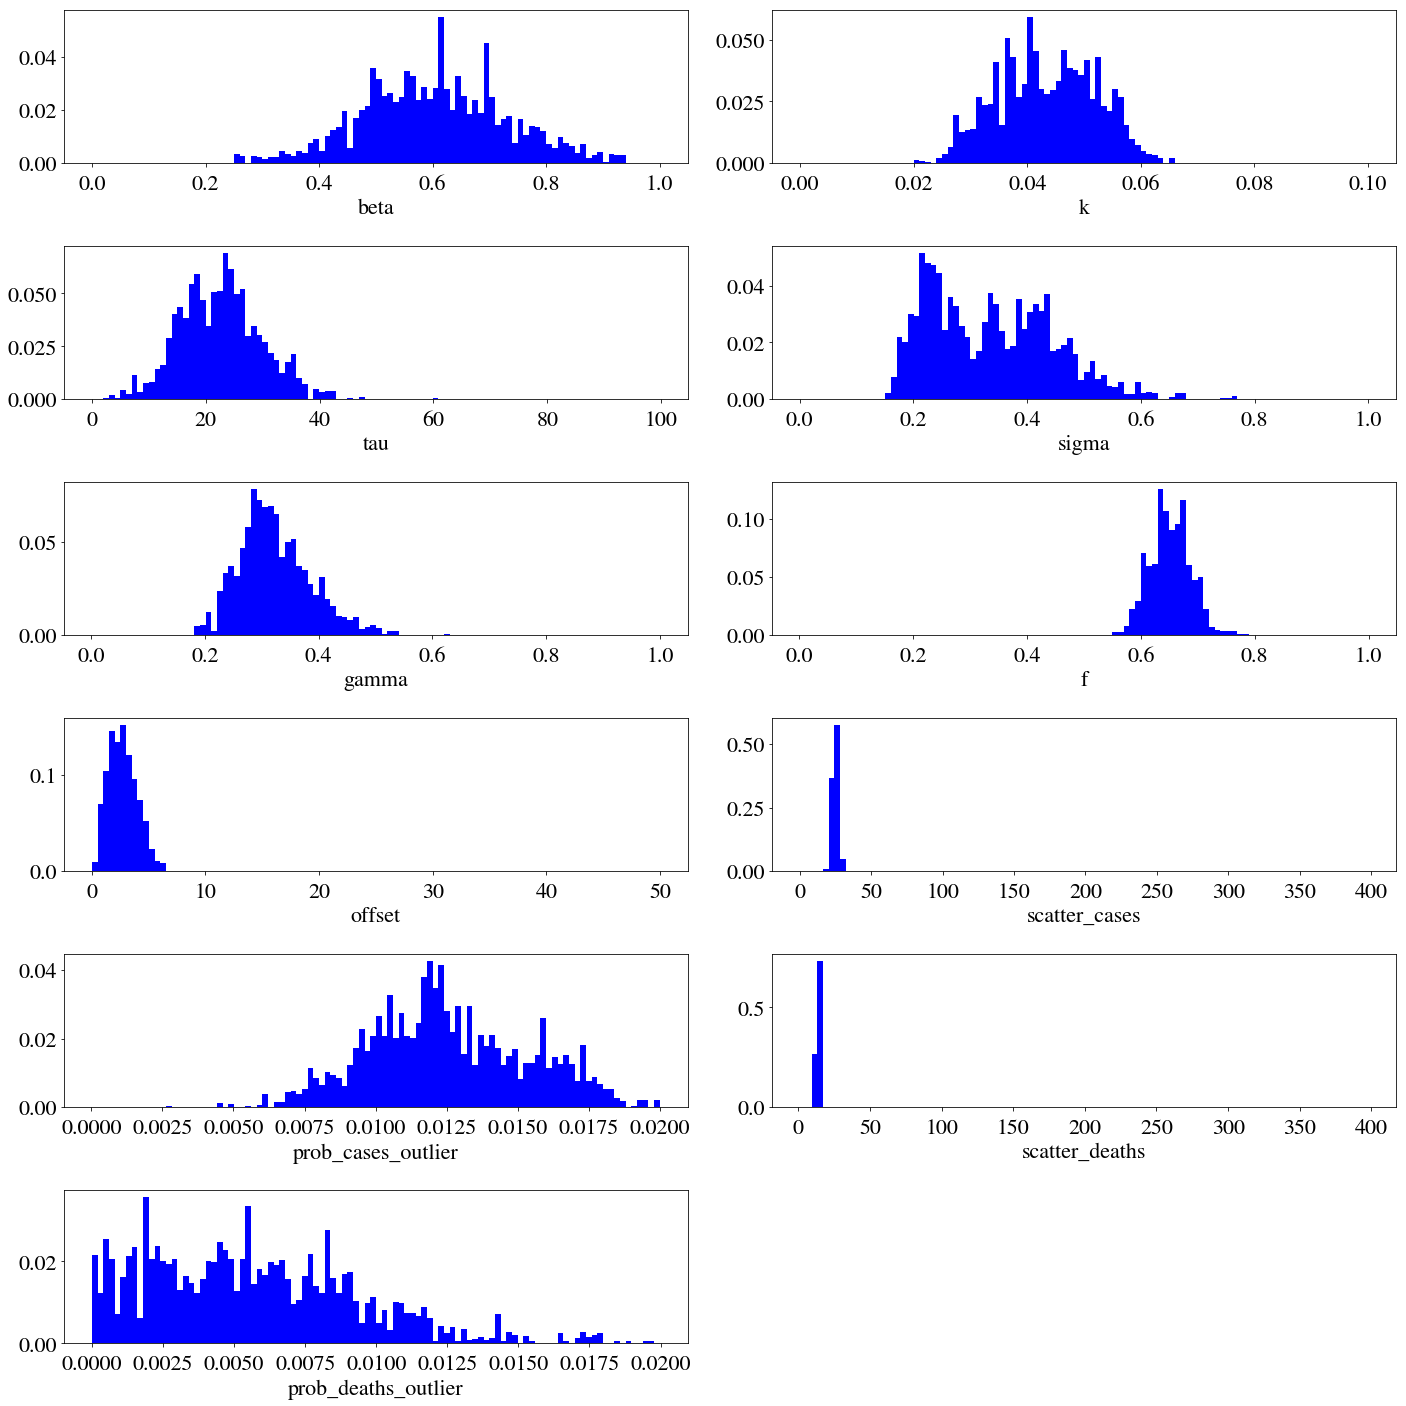

In [14]:
# examine parameter histograms
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    n, b, patches = plt.hist(chain[:,i], weights=weight, bins=100, color='b', histtype='stepfilled', log=False)
    plt.xlabel(p)
    plt.tight_layout()
plt.savefig('plots/nnest_param_hist_{}.pdf'.format(country))

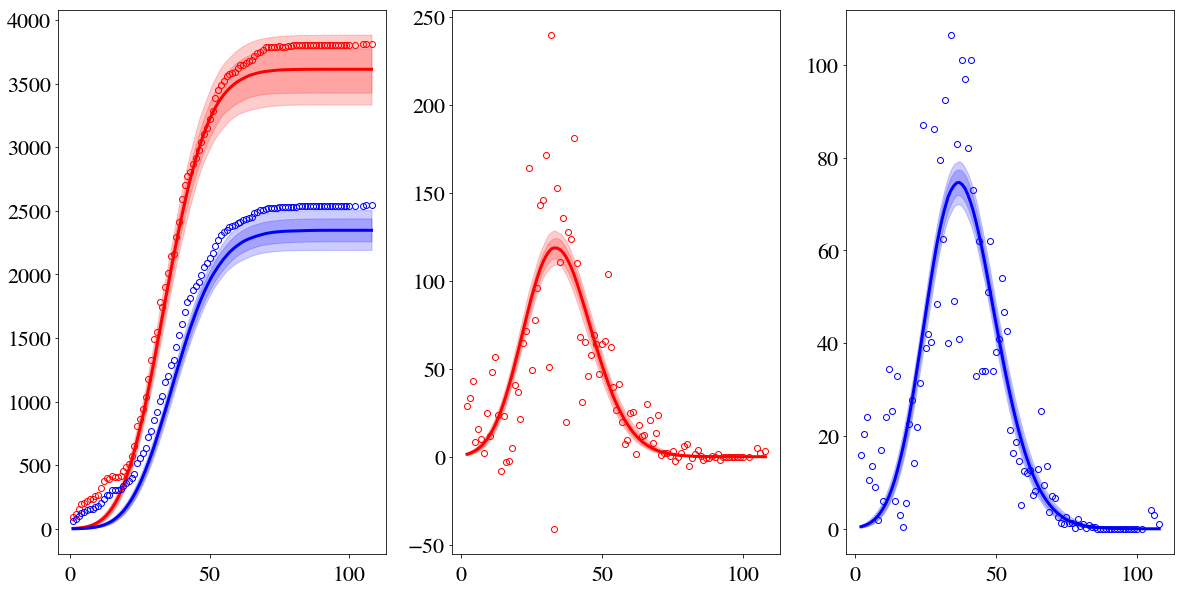

In [15]:
selection = np.random.choice(len(chain), 1000, replace=True, p=weight)
e.makeplot(samples=chain[selection])
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/nnest_fit_intervals_{}.pdf'.format(country))

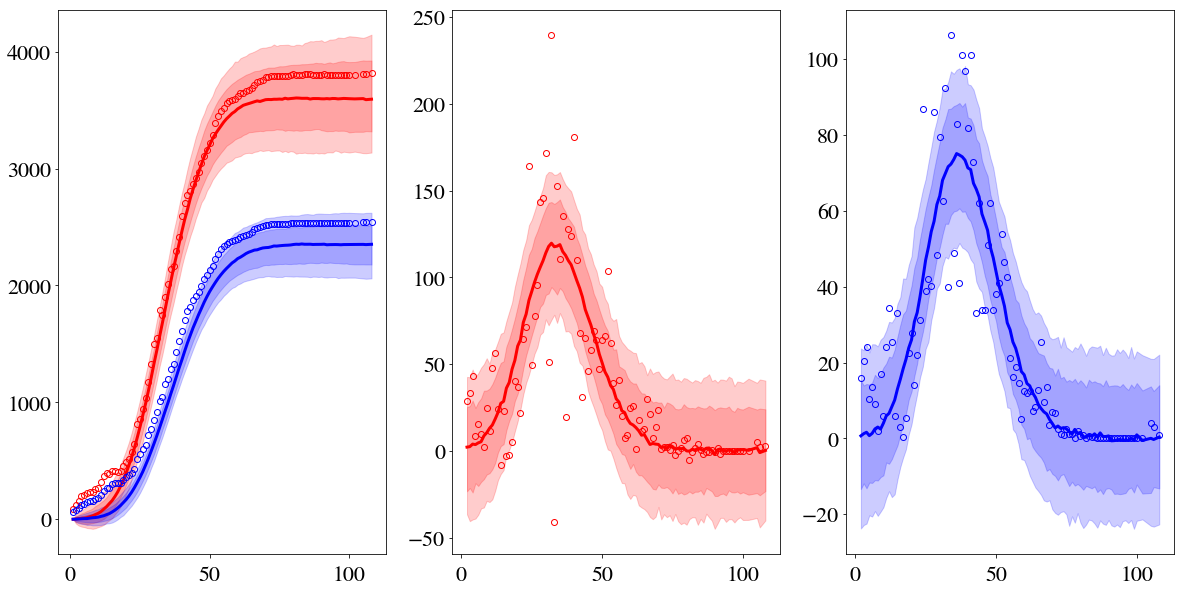

In [16]:
e.makeplot(samples=chain[selection], scatter=True)
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/nnest_fit_intervals_scatter_{}.pdf'.format(country))

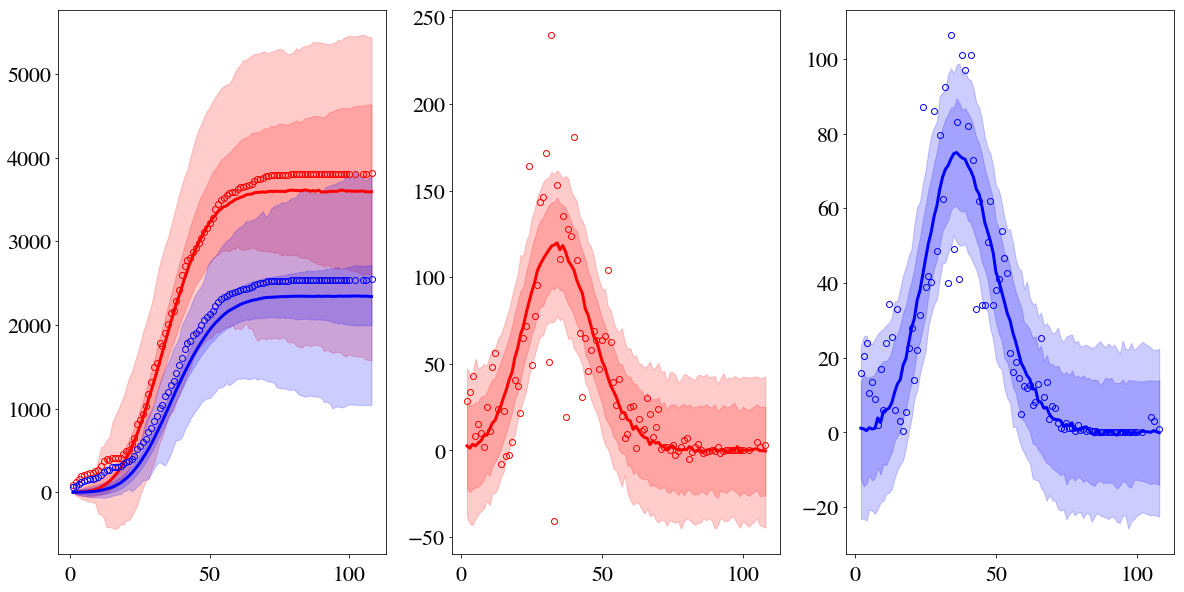

In [17]:
e.makeplot(samples=chain[selection], scatter=True, outliers=True)
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/nnest_fit_intervals_outliers_{}.pdf'.format(country))

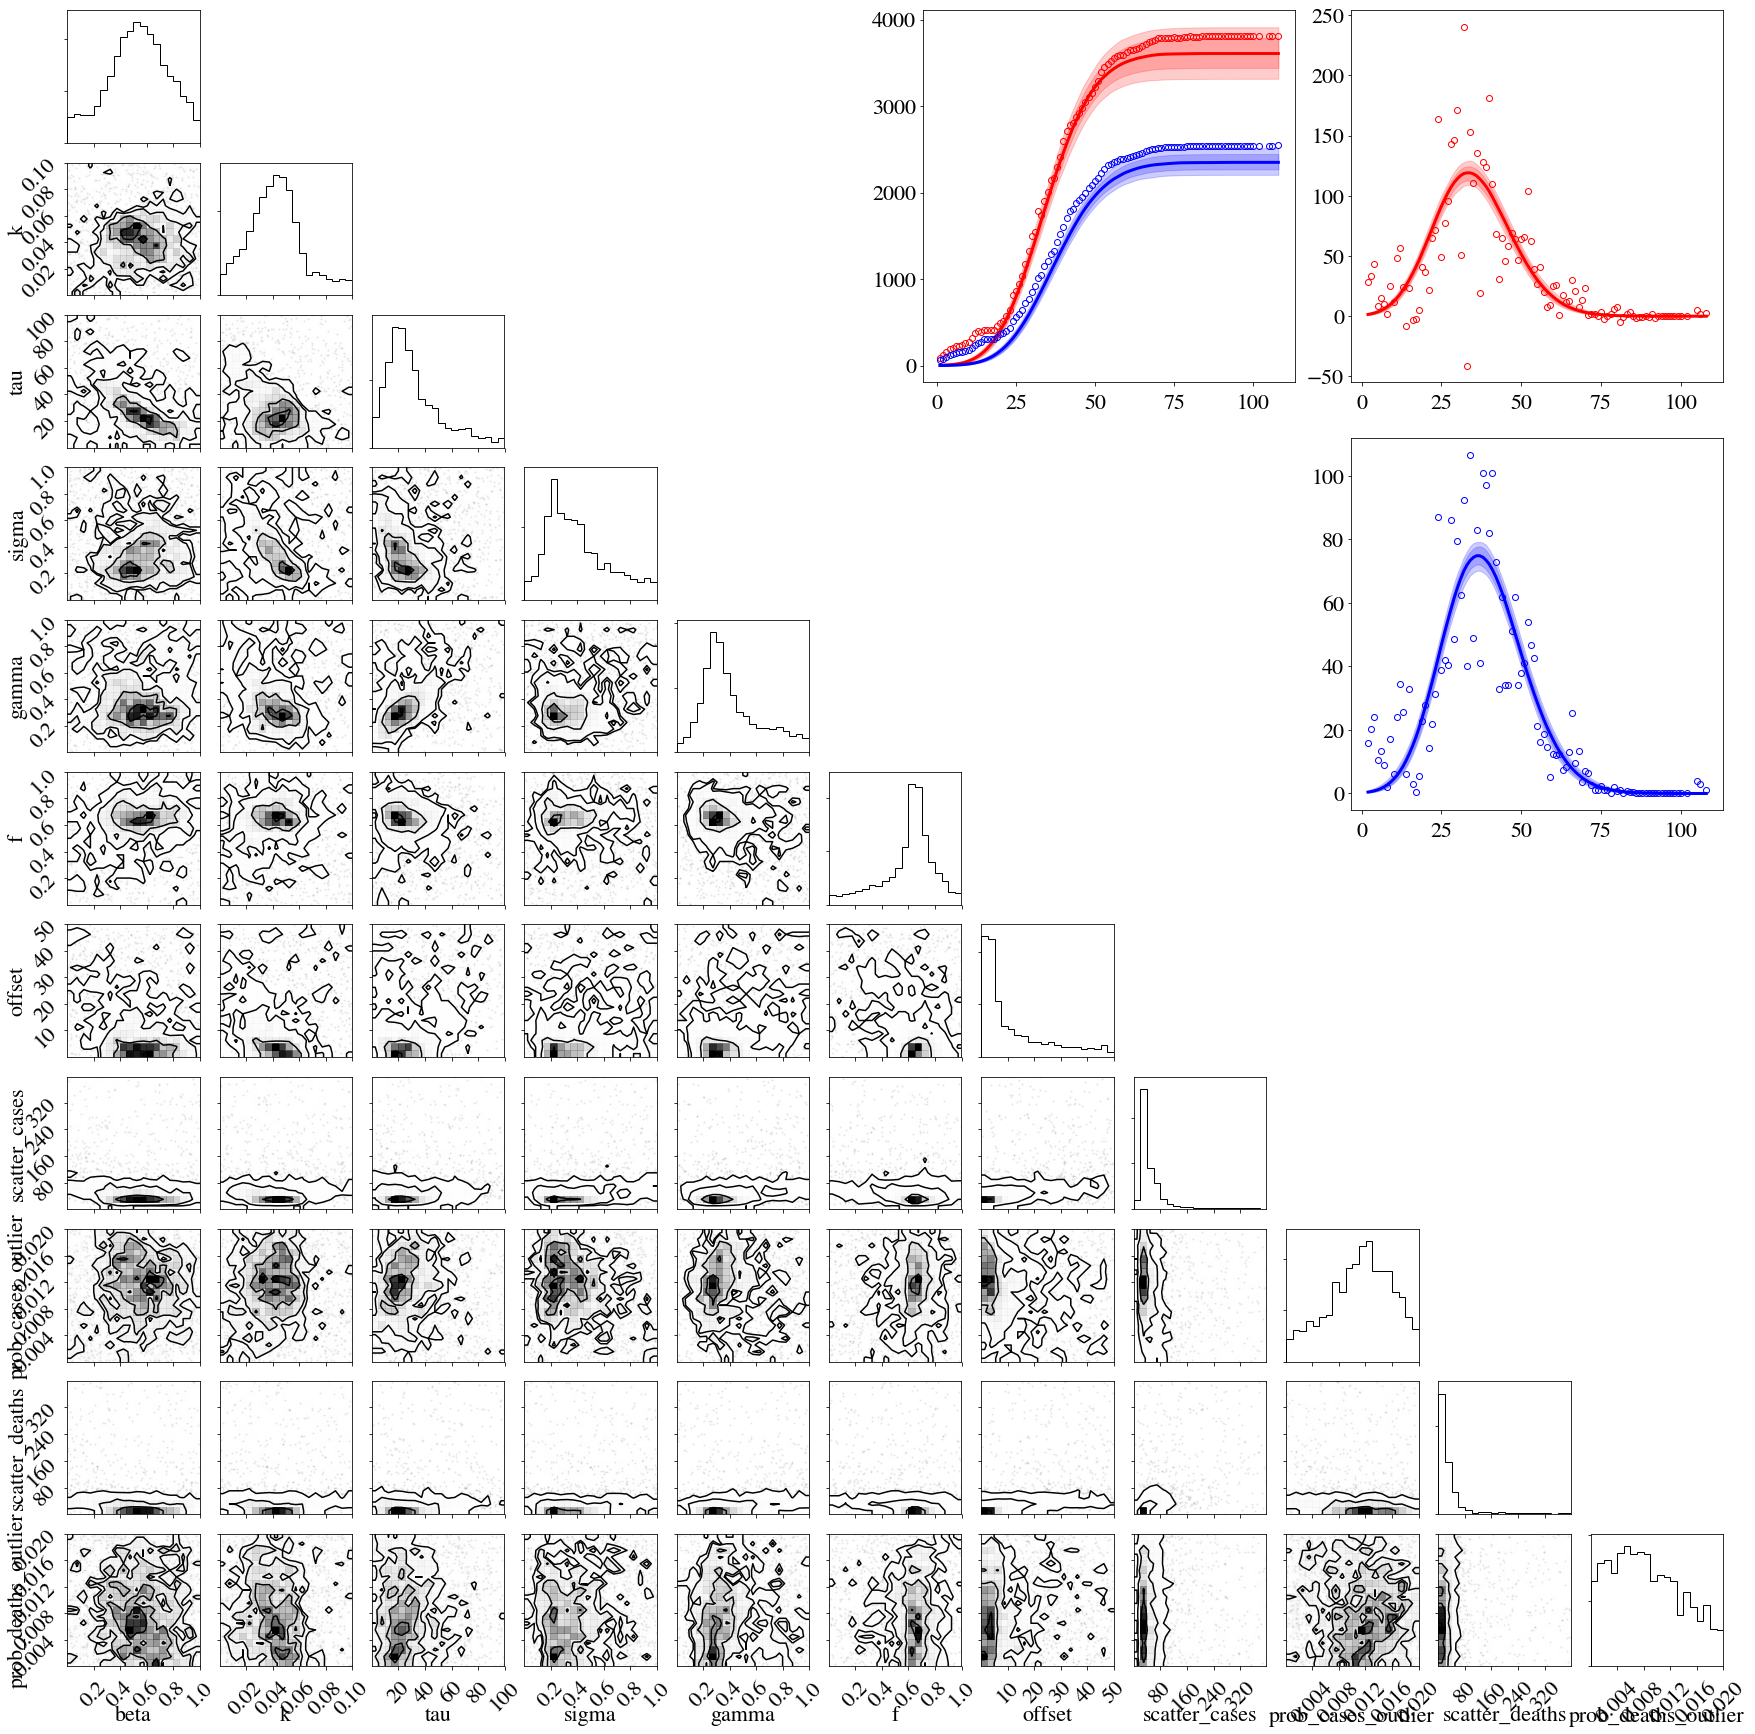

In [18]:
corner.corner(chain, labels=par)
ax0 = plt.subplot(4, 4, 3)
ax1 = plt.subplot(4, 4, 4)
ax2 = plt.subplot(4, 4, 8)
selection = np.random.choice(len(chain), 1000, replace=True, p=weight)
e.makeplot(samples=chain[selection], ax=(ax0, ax1, ax2))
plt.subplots_adjust(wspace=0.15, hspace=0.15);
plt.savefig('plots/nnest_corner_{}.pdf'.format(country))